0016E5_08430.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


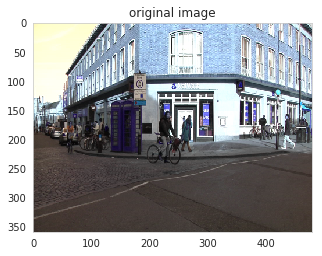

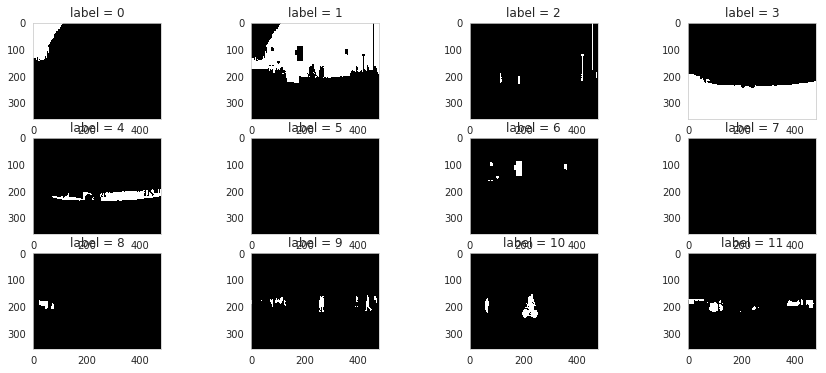

In [4]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

import cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,6))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()



In [5]:
plt.imread(dir_img + fnm).shape, plt.imread(dir_seg + fnm).shape

((360, 480, 3), (360, 480))

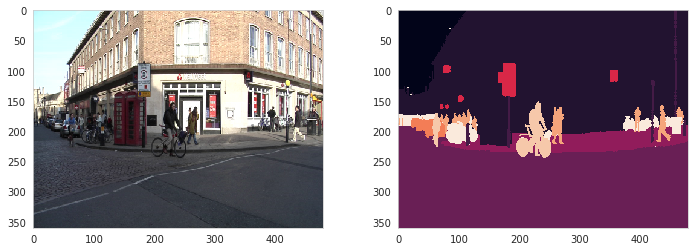

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(plt.imread(dir_img + fnm))
ax[1].imshow(plt.imread(dir_seg + fnm))

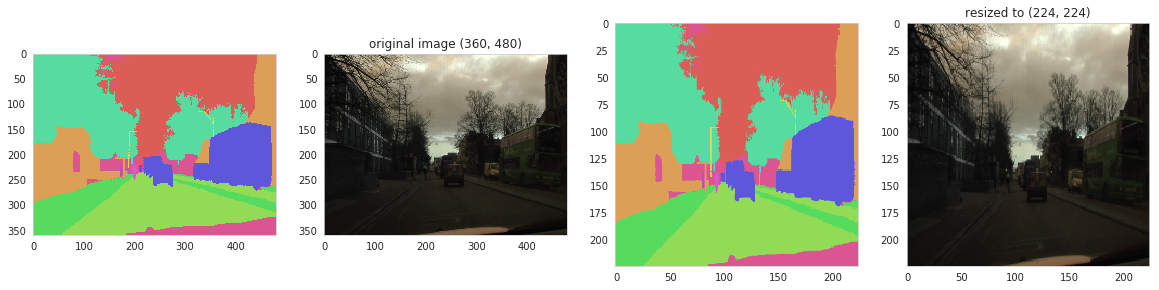

In [7]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),1,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [8]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
from keras.utils import plot_model 

warnings.filterwarnings("ignore")

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "2" 
# set_session(tf.Session(config=config))   

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]
keras version 2.2.4
tensorflow version 1.12.0


Using TensorFlow backend.


In [9]:
from keras.applications.mobilenet import MobileNet

def FCN8(nClasses, input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    n = 512
    o = Conv2D(n, (7,7), activation='relu', padding='same', name="conv6")(mobilenet.output)
    conv7 = Conv2D(n, (1,1), activation='relu', padding='same', name="conv7")(o)

    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose(nClasses, (4,4), strides=(4,4), use_bias=False )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = Conv2D( nClasses, (1,1),activation='relu', padding='same', name="pool4_11")(mobilenet.get_layer('conv_pw_11_relu').output)
    pool411_2 = Conv2DTranspose(nClasses, (2,2), strides=(2,2), use_bias=False )(pool411)

    pool311 = Conv2D(nClasses, (1,1), activation='relu' , padding='same', name="pool3_11")(mobilenet.get_layer('conv_pw_5_relu').output)

    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
    o = Activation('softmax', name='seg_map')(o)

    model = Model(mobilenet.input, o)
    return model

In [12]:
fcn8_m = FCN8(12)
fcn8_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
__________

In [10]:
def build_desc():
    inp = Input(shape=(224,224,12))
    x = inp
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid', name='desc')(x)

    model = Model(inp,x)
    
    return model

In [11]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels



input_width , input_height = 224, 224
images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [12]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [13]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [10]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint#, LearningRateScheduler


# LOG_FILE_PATH = 'fcn-chkt/fcn8-baseline.hdf5'#-{epoch:02d}-{mean_iou:.4f}.hdf5'
# checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
#                              verbose=1, 
#                              save_best_only=True)

# early_stop = EarlyStopping(patience=5,
# #                            monitor='val_loss', 
# #                            min_delta=0.001, 
# #                            mode='min', 
#                            verbose=1)

# reduce_lr = ReduceLROnPlateau(factor=0.2, 
# #                               monitor='val_loss', 
#                               patience=2, 
#                               min_lr=1e-8)
                              
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.optimizers import Adam


with tf.device('/cpu:0'):
#     model = build_model(inputs)
    model = FCN8(nClasses = n_classes, input_height = 224, input_width  = 224)
#     wt_dir1 = '../weights/improved-baseline/attention_more_data_wts_1.6000001e-06_0.068.npy'
#     w_load = np.load(wt_dir1)
#     load= True
#     if load:
#         model.set_weights(w_load)
#     #     model.set_weights(wss)
#         print("loaded weights successfully")
    print("built model successfully")
    
    
optimizer = Adam(lr=0.5e-2, beta_1=0.9, beta_2=0.999)

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss = 'categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=[mean_iou])
#               metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])




built model successfully


In [12]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint#, LearningRateScheduler


LOG_FILE_PATH = 'fcn-chkt/fcn8-GAN.hdf5'#-{epoch:02d}-{mean_iou:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
                             verbose=1, 
                             save_best_only=True)

early_stop = EarlyStopping(patience=5,
#                            monitor='val_loss', 
#                            min_delta=0.001, 
#                            mode='min', 
                           verbose=1)

reduce_lr = ReduceLROnPlateau(factor=0.2, 
#                               monitor='val_loss', 
                              patience=2, 
                              min_lr=1e-7) 

call_backs = [early_stop, reduce_lr, checkpoint]



In [11]:
X.shape, Y.shape, X_train.shape, y_train.shape

((367, 224, 224, 3),
 (367, 224, 224, 12),
 (311, 224, 224, 3),
 (311, 224, 224, 12))

In [ ]:
parallel_model.compile(loss = 'categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=[mean_iou])

In [12]:
idx = np.random.permutation(X_train.shape[0])
new_train = X_train[idx]
new_train.shape

(311, 224, 224, 3)

In [11]:
import keras
def custom_loss(y_true, y_pred):
    seg_loss = keras.losses.categorical_crossentropy(y_true[0], y_pred[0])
    adv_loss = keras.losses.binary_crossentropy(y_true[1], y_pred[1])
    return seg_loss + 0.2*adv_loss

In [17]:
from keras.optimizers import Adam
discriminator = build_desc()
desc_optm     = Adam(lr=1e-3)

discriminator.compile( loss      = 'binary_crossentropy',
                       optimizer = desc_optm,
                       metrics   = ['accuracy'])

fcn_model = FCN8(nClasses     = n_classes,  
                 input_height = 224, 
                 input_width  = 224)


fcn_inp = Input(shape=(224,224,3))
seg_out = fcn_model(fcn_inp)

# real = Input(shape=(128,128,3))
# The discriminator takes generated images as input and determines validity
discriminator.trainable = False
seg_desc = discriminator(seg_out)

from keras.layers import Lambda

seg_map_ = Lambda(lambda x: x, name='seg_map_')(seg_out)
desc_ = Lambda(lambda x: x, name='desc_')(seg_desc)

combine_model = Model(fcn_inp, [seg_map_, desc_])

losses = {
    "seg_map_": "categorical_crossentropy",
    "desc_"   : "binary_crossentropy",
}
lossWeights = {
    "seg_map_": 1.0, 
    "desc_": 0.2
}
metrics_ = {
    "seg_map_" : mean_iou,
    "desc_"    : "accuracy",
}

combine_model.compile(  optimizer=Adam(lr=1e-3), 
                loss=losses, 
                loss_weights=lossWeights,
                metrics=metrics_)#["accuracy"])

In [18]:
batch_size = 5
# valid = np.zeros((batch_size, 1))
# real  = np.zeros((batch_size, 1))

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
    
idx = np.random.permutation(X_train.shape[0])
new_train = X_train[idx]
new_test  = y_train[idx]
X_tr_batch = new_train[:batch_size]
y_tr_batch = new_test[:batch_size]
del new_train, new_test



In [19]:
X_tr_batch.shape, y_tr_batch.shape, valid.shape, fake.shape

((5, 224, 224, 3), (5, 224, 224, 12), (5, 1), (5, 1))

In [18]:
gen = fcn_model.predict(X_tr_batch)
d_loss_real = desc.train_on_batch(y_tr_batch, valid)
d_loss_fake = desc.train_on_batch(gen, fake)
d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
d_loss_fake, d_loss_real, d_loss

([1.8303016, 0.2],
 [1.160411, 0.4],
 array([1.4953563, 0.3      ], dtype=float32))

In [19]:
test_p = combine.predict(X_tr_batch)
test_p[0].shape, test_p[1].shape

((5, 224, 224, 12), (5, 1))

In [20]:
combine.train_on_batch(X_tr_batch, [y_tr_batch, valid])

[2.7615108, 2.4870408, 1.3723508, 0.08248565, 0.2]

In [21]:
combine_model.metrics_names, discriminator.metrics_names

(['loss', 'seg_map__loss', 'desc__loss', 'seg_map__mean_iou', 'desc__acc'],
 ['loss', 'acc'])

In [25]:
X_train.shape, np.sqrt(311), 311/30.0

((311, 224, 224, 3), 17.635192088548397, 10.366666666666667)

In [ ]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
    
idx = np.random.permutation(X_train.shape[0])
new_train = X_train[idx]
new_test  = y_train[idx]
X_tr_batch = new_train[:batch_size]
y_tr_batch = new_test[:batch_size]
del new_train, new_test


In [30]:

batch_size = 30

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

itrs = 10
epochs = 100
d_loss_store, d_acc_store = [], []
g_loss_store, g_acc_store = [], []
s_loss_store, s_acc_store = [], []
for epoch in range(epochs):

    idx = np.random.permutation(X_train.shape[0])
    X_train = X_train[idx]
    y_train  = y_train[idx]
    
    for itr in range(itrs):
        
        # ---------------------
        #  Prepare Batch of data
        # ---------------------
        X_batch = X_train[itr*batch_size : (itr+1)*batch_size]
        y_batch = y_train[itr*batch_size : (itr+1)*batch_size]


        # ---------------------
        #  Train Discriminator
        # ---------------------
        seg_gen = fcn_model.predict(X_batch)

        d_loss_acc_real = discriminator.train_on_batch(y_batch, valid)
        d_loss_acc_fake = discriminator.train_on_batch(seg_gen, fake)
        d_loss_acc = 0.5 * np.add(d_loss_acc_real, d_loss_acc_fake)

        d_loss_store.append(d_loss_acc[0])
        d_acc_store.append(d_loss_acc[1])
        

        # ---------------------
        #  Train Seg-Gen
        # ---------------------
        gen_all = combine_model.train_on_batch(X_batch, [y_batch, valid])

        #(['loss', 'seg_map__loss', 'desc__loss', 'seg_map__mean_iou', 'desc__acc'],
        g_loss_store.append(gen_all[2])
        g_acc_store.append(gen_all[-1])

        s_loss_store.append(gen_all[1])
        s_acc_store.append(gen_all[3])


    # Plot the progress
    print("epoch   : ", epoch)
    print("seg_loss: ", np.mean(s_loss_store[epoch*itrs : (epoch+1)*itrs]))
    print("seg_acc : ", np.mean(s_acc_store[epoch*itrs : (epoch+1)*itrs]))
    print("des_loss: ", np.mean(d_loss_store[epoch*itrs : (epoch+1)*itrs]))
    print("gen_loss: ", np.mean(g_loss_store[epoch*itrs : (epoch+1)*itrs]))
    
    print("===========================")
    

epoch   :  0
seg_loss:  2.810169
seg_acc :  0.46700072
des_loss:  0.4919181
gen_loss:  9.252415
epoch   :  1
seg_loss:  2.3772883
seg_acc :  0.47541696
des_loss:  0.15169582
gen_loss:  16.09701
epoch   :  2
seg_loss:  2.113801
seg_acc :  0.4836789
des_loss:  0.010323031
gen_loss:  10.059994
epoch   :  3
seg_loss:  2.7959552
seg_acc :  0.49383932
des_loss:  0.036515694
gen_loss:  0.9663602
epoch   :  4
seg_loss:  2.8328338
seg_acc :  0.4940769
des_loss:  0.041270968
gen_loss:  12.626172
epoch   :  5
seg_loss:  1.8156984
seg_acc :  0.49379817
des_loss:  0.005988557
gen_loss:  16.118097
epoch   :  6
seg_loss:  1.4058979
seg_acc :  0.5007169
des_loss:  0.0026804674
gen_loss:  16.118097
epoch   :  7
seg_loss:  1.3404155
seg_acc :  0.51173407
des_loss:  0.010859919
gen_loss:  14.478956
epoch   :  8
seg_loss:  2.271872
seg_acc :  0.52727157
des_loss:  1.4412726
gen_loss:  12.18785
epoch   :  9
seg_loss:  1.4201591
seg_acc :  0.5389234
des_loss:  0.078967236
gen_loss:  15.901108
epoch   :  10


epoch   :  76
seg_loss:  0.7035044
seg_acc :  0.6411556
des_loss:  4.818303e-06
gen_loss:  16.118097
epoch   :  77
seg_loss:  0.701697
seg_acc :  0.6425627
des_loss:  1.2300334e-05
gen_loss:  16.118097
epoch   :  78
seg_loss:  0.683257
seg_acc :  0.64399374
des_loss:  3.3583674e-06
gen_loss:  16.118097
epoch   :  79
seg_loss:  0.67684203
seg_acc :  0.6454426
des_loss:  9.431666e-06
gen_loss:  16.118097
epoch   :  80
seg_loss:  0.6679468
seg_acc :  0.6468839
des_loss:  2.5755048e-06
gen_loss:  16.118097
epoch   :  81
seg_loss:  0.6659836
seg_acc :  0.64832646
des_loss:  1.5832799e-06
gen_loss:  16.118097
epoch   :  82
seg_loss:  0.657973
seg_acc :  0.64976686
des_loss:  8.739129e-06
gen_loss:  16.118097
epoch   :  83
seg_loss:  0.64718056
seg_acc :  0.65118486
des_loss:  1.0167537e-05
gen_loss:  16.118097
epoch   :  84
seg_loss:  0.64013886
seg_acc :  0.6526331
des_loss:  7.975317e-06
gen_loss:  16.118097
epoch   :  85
seg_loss:  0.6373292
seg_acc :  0.6540587
des_loss:  7.36316e-06
gen

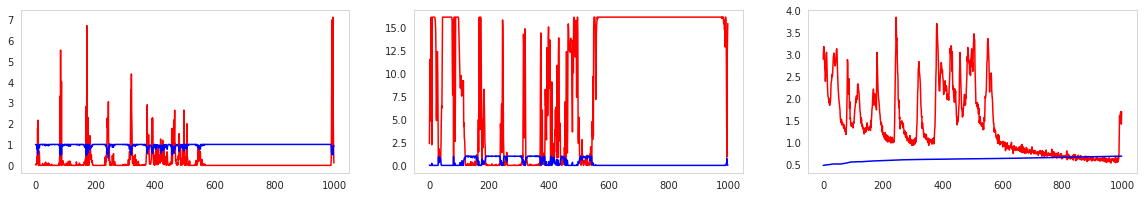

In [32]:
fig, ax = plt.subplots(1,3,figsize=(20,3))
ax[0].plot(d_loss_store, 'r')
ax[1].plot(g_loss_store, 'r')
ax[2].plot(s_loss_store, 'r')

ax[0].plot(d_acc_store, 'b')
ax[1].plot(g_acc_store, 'b')
ax[2].plot(s_acc_store, 'b')


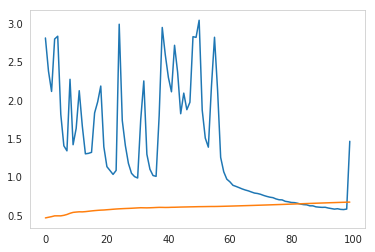

In [33]:
s_loss = [np.mean(s_loss_store[i*10 : (i+1)*10]) for i in range(100)]
s_acc  = [np.mean(s_acc_store[i*10 : (i+1)*10]) for i in range(100)]

plt.plot(s_loss)
plt.plot(s_acc)

In [36]:
preds = combine_model.predict(X_test[:5])
preds[0].shape

(5, 224, 224, 12)

In [14]:
EPOCHS = 100
print("let's start parallel model for 100 epochs")
parallel_model.fit( x                = X_train, 
                    y                = y_train, 
                    batch_size       = 100, 
                    epochs           = EPOCHS, 
                    verbose          = 1, 
                    callbacks        = call_backs, 
                    validation_data  = (X_test,y_test), 
                    shuffle          = True, 
                    initial_epoch    = 0)

let's start parallel model for 100 epochs
Train on 311 samples, validate on 56 samples
Epoch 1/100
311/311 [==============================] - 10s 33ms/step - loss: 0.9645 - mean_iou: 0.5722 - val_loss: 1.5317 - val_mean_iou: 0.5866

Epoch 00001: val_loss improved from 1.80413 to 1.53174, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 2/100
311/311 [==============================] - 8s 25ms/step - loss: 0.9374 - mean_iou: 0.5949 - val_loss: 1.4245 - val_mean_iou: 0.6051

Epoch 00002: val_loss improved from 1.53174 to 1.42452, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 3/100
311/311 [==============================] - 8s 25ms/step - loss: 0.9036 - mean_iou: 0.6109 - val_loss: 1.5865 - val_mean_iou: 0.6185

Epoch 00003: val_loss did not improve from 1.42452
Epoch 4/100
311/311 [==============================] - 8s 25ms/step - loss: 0.8883 - mean_iou: 0.6214 - val_loss: 1.7586 - val_mean_iou: 0.6270

Epoch 00004: val_loss did not improve from 1.42452
Epoch 5/100
311/311 [=========

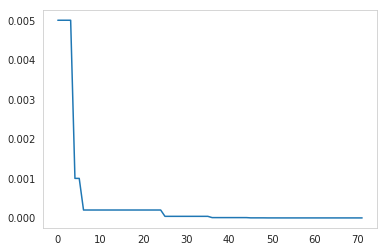

In [18]:
plt.plot(parallel_model.history.history['lr'])

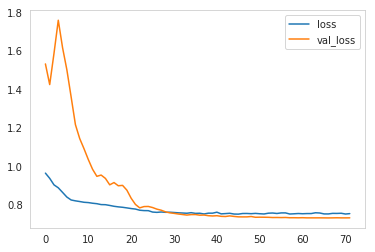

In [15]:
for key in ['loss', 'val_loss']:
    plt.plot(parallel_model.history.history[key],label=key)
plt.legend()
plt.show()


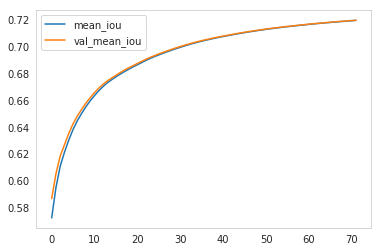

In [16]:
for key in ['mean_iou', 'val_mean_iou']:
    plt.plot(parallel_model.history.history[key],label=key)
plt.legend()
plt.show()


In [19]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)


(56, 224, 224) (56, 224, 224)


In [20]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)


class 00: #TP=403062, #FP= 60711, #FN=22117, IoU=0.830
class 01: #TP=621962, #FP=313267, #FN=51579, IoU=0.630
class 02: #TP=     0, #FP=    16, #FN=31552, IoU=0.000
class 03: #TP=912828, #FP= 74390, #FN=37051, IoU=0.891
class 04: #TP= 38999, #FP= 34367, #FN=79058, IoU=0.256
class 05: #TP=109742, #FP= 42367, #FN=151900, IoU=0.361
class 06: #TP=     0, #FP=    43, #FN=32959, IoU=0.000
class 07: #TP=     0, #FP=     9, #FN=33727, IoU=0.000
class 08: #TP=112282, #FP= 78245, #FN=42613, IoU=0.482
class 09: #TP=     0, #FP=    27, #FN=15787, IoU=0.000
class 10: #TP=     0, #FP=    20, #FN=11584, IoU=0.000
class 11: #TP=  6988, #FP=   531, #FN=94066, IoU=0.069
_________________
Mean IoU: 0.293


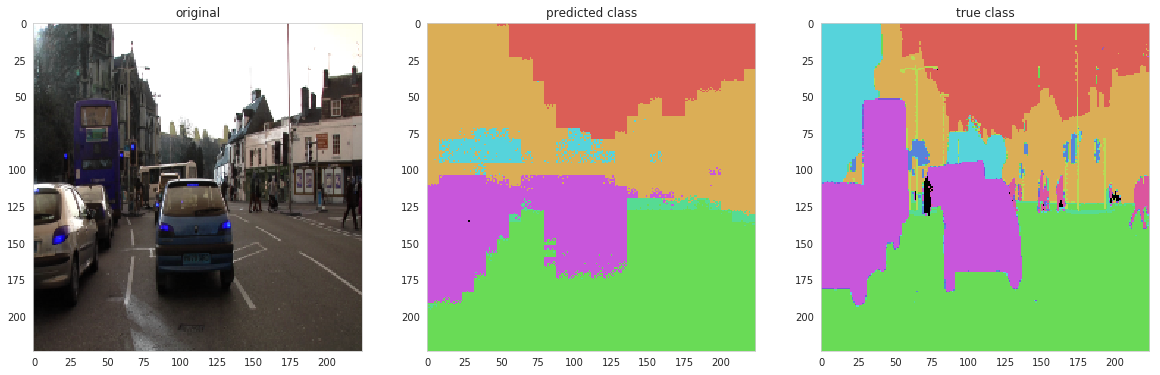

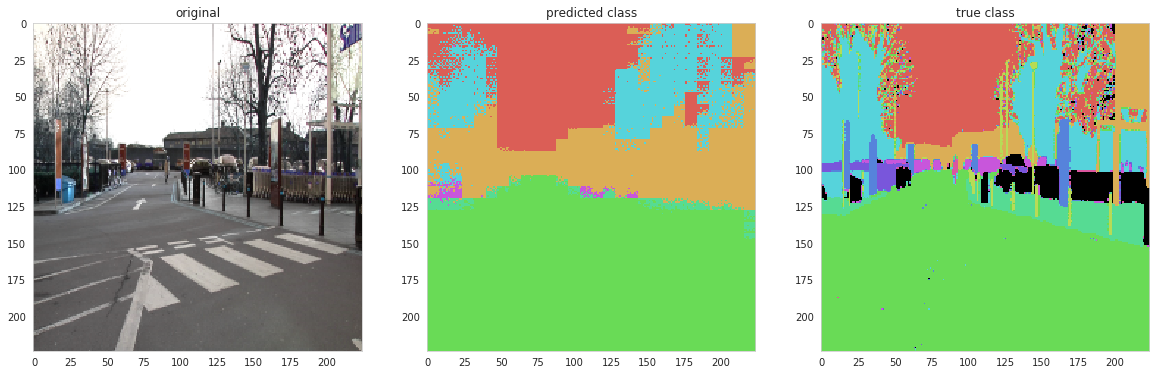

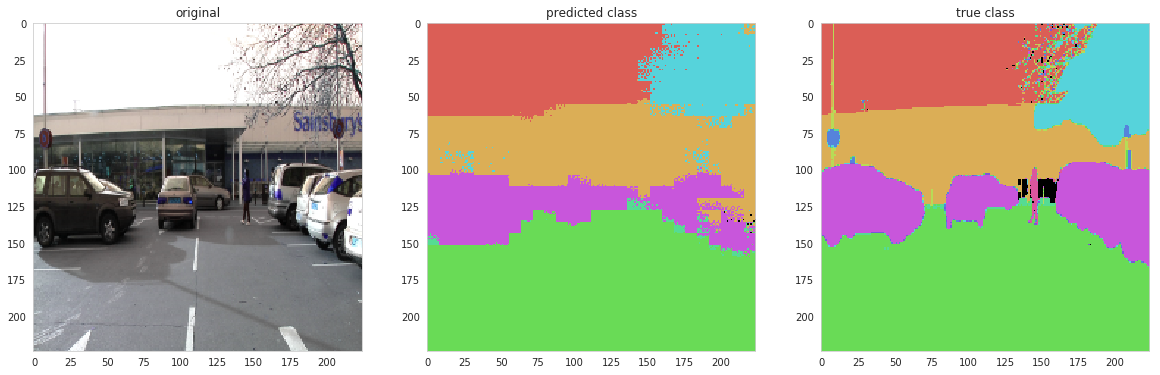

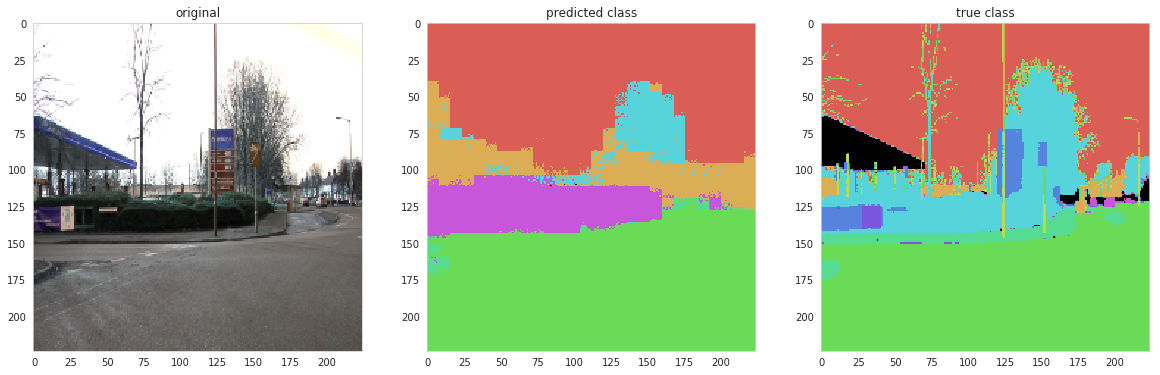

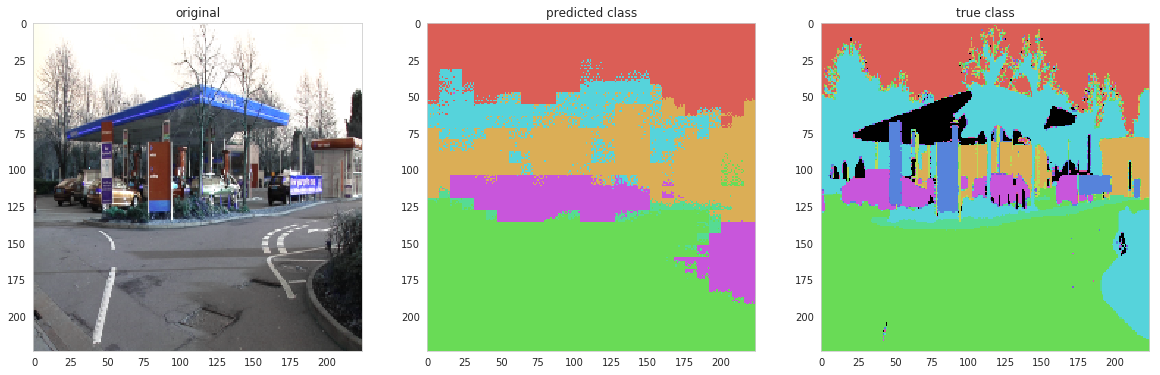

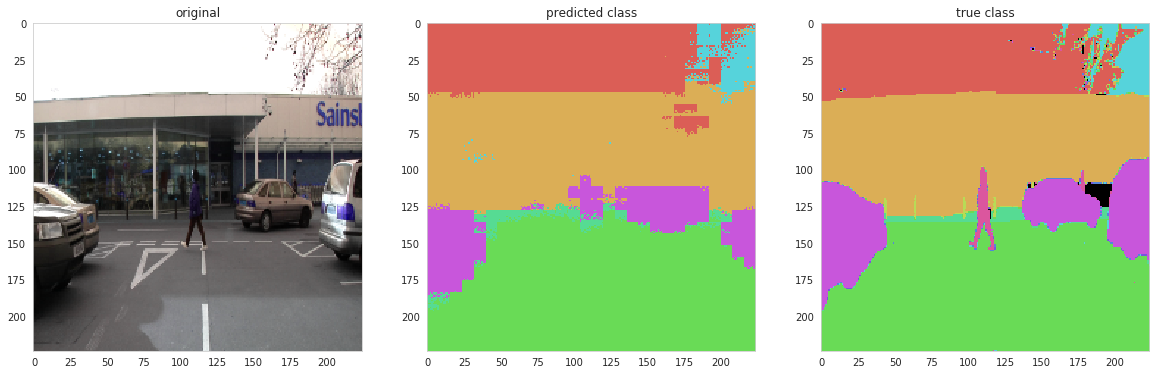

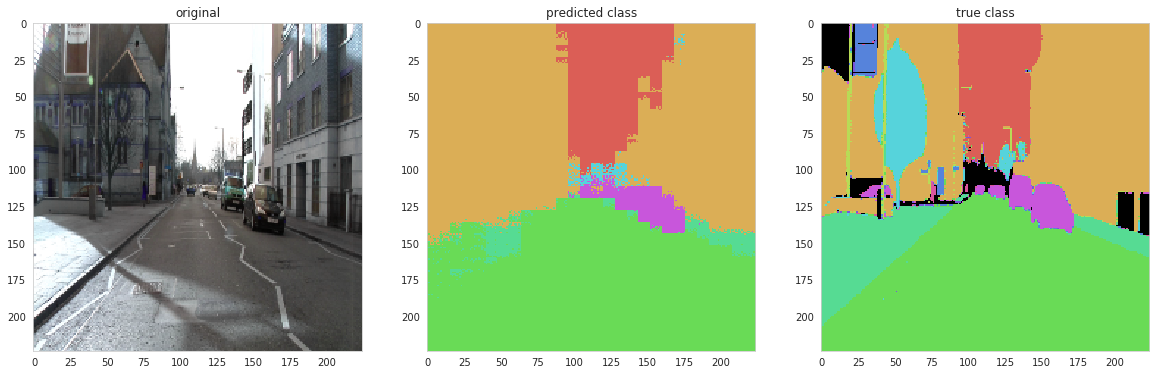

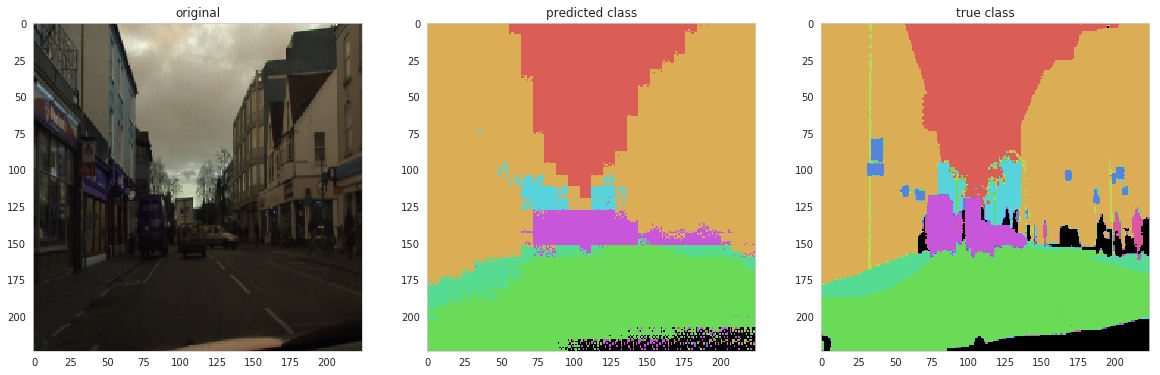

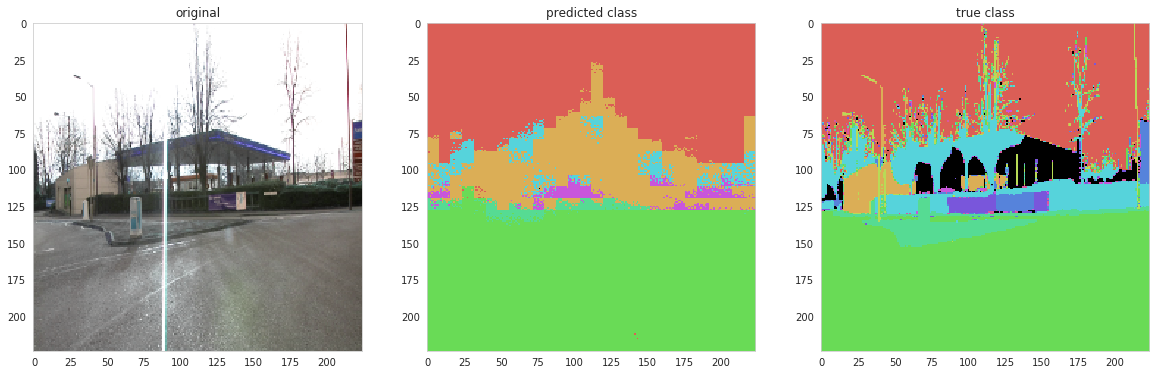

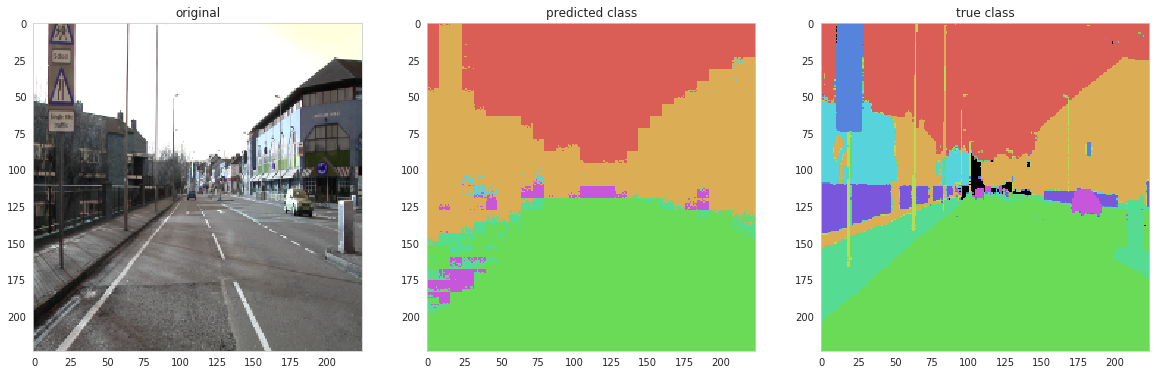

In [22]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,20))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()